In [1]:
!pip install transformers datasets --quiet

In [2]:
from datasets import load_dataset
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification
from torch.optim import AdamW
import torch
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score
from tqdm import tqdm

In [3]:
# Step 1: Load tokenizer and dataset
tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")
dataset = load_dataset("imdb")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/7.81k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

unsupervised-00000-of-00001.parquet:   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [4]:
# Step 2: Tokenize the full dataset
def tokenize_function(batch):
    return tokenizer(batch["text"], padding="max_length", truncation=True, max_length=512)

encoded_dataset = dataset.map(tokenize_function, batched=True)
encoded_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])

# Step 3: DataLoader
train_dataset = encoded_dataset["train"]
test_dataset = encoded_dataset["test"]

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True,pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=32,pin_memory=True)

# Step 4: Load model
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)
device = torch.device("cuda"if torch.cuda.is_available() else "cpu")
model.to(device)

# Compute class weights for weighted loss
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

labels = np.array(train_dataset["label"])
class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(labels), y=labels)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)

# Use weighted loss inside training loop
optimizer = AdamW(model.parameters(), lr=5e-5)
epochs = 5
train_losses = []
val_accuracies = []
val_losses = []

# Step 5: Training loop
model.train()
for epoch in range(epochs):
    print(f"Epoch {epoch+1}")
    total_loss = 0
    for batch in tqdm(train_loader):
        batch = {k: v.to(device) for k, v in batch.items()}
        batch["labels"] = batch.pop("label")

        outputs = model(**batch)
        loss = torch.nn.functional.cross_entropy(outputs.logits, batch["labels"], weight=class_weights_tensor)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    train_losses.append(avg_loss)

    # Step 6: Evaluation
    model.eval()
    all_preds = []
    all_labels = []
    total_val_loss = 0

    with torch.no_grad():
        for batch in test_loader:
            batch = {k: v.to(device) for k, v in batch.items()}
            batch["labels"] = batch.pop("label")

            outputs = model(**batch)
            preds = outputs.logits.argmax(dim=1).cpu().numpy()
            labels = batch["labels"].cpu().numpy()

            val_loss = torch.nn.functional.cross_entropy(outputs.logits, batch["labels"], weight=class_weights_tensor)
            total_val_loss += val_loss.item()

            all_preds.extend(preds)
            all_labels.extend(labels)

    acc = accuracy_score(all_labels, all_preds)
    val_accuracies.append(acc)
    val_losses.append(total_val_loss / len(test_loader))
    model.train()

# Save model
model.save_pretrained("./finetuned_distilbert")
tokenizer.save_pretrained("./finetuned_distilbert")

print(f"\n✅ Full test set accuracy: {acc:.2f}")

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/50000 [00:00<?, ? examples/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1


100%|██████████| 782/782 [03:48<00:00,  3.43it/s]


Epoch 2


100%|██████████| 782/782 [03:47<00:00,  3.44it/s]


Epoch 3


100%|██████████| 782/782 [03:47<00:00,  3.44it/s]


Epoch 4


100%|██████████| 782/782 [03:47<00:00,  3.44it/s]


Epoch 5


100%|██████████| 782/782 [03:47<00:00,  3.44it/s]



✅ Full test set accuracy: 0.92


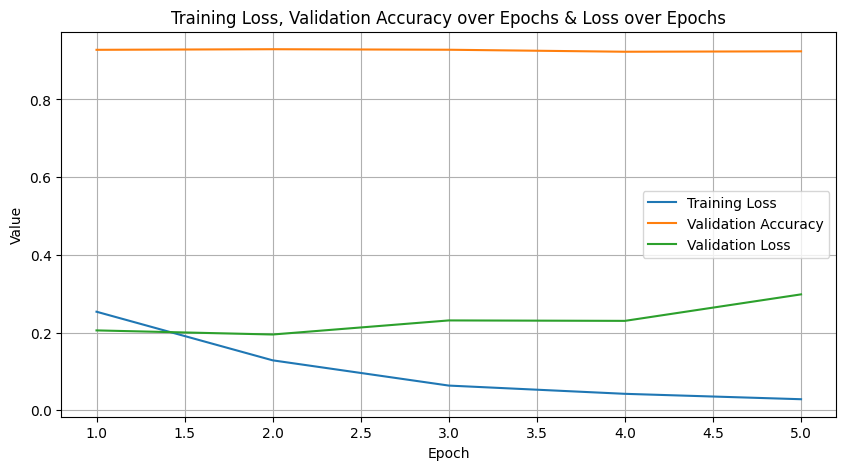

In [5]:
import matplotlib.pyplot as plt

epochs_range = range(1, len(train_losses) + 1)

plt.figure(figsize=(10, 5))
plt.plot(epochs_range, train_losses, label="Training Loss")
plt.plot(epochs_range, val_accuracies, label="Validation Accuracy")
plt.plot(epochs_range, val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Value")
plt.title("Training Loss, Validation Accuracy over Epochs & Loss over Epochs")
plt.legend()
plt.grid(True)
plt.show()
